In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx as dx
from scipy.signal import sawtooth, square
from scipy.fft import rfft, rfftfreq, irfft
from time import sleep
import sounddevice as sd
from scipy.io.wavfile import write
import os
import time
from scipy import integrate

class MyDAQ:
    def __init__(self):
        self.__samplerate = None
        self.__name = None

    @property
    def samplerate(self) -> int:
        return self.__samplerate

    @samplerate.setter
    def samplerate(self, newSamplerate: int) -> None:
        assert isinstance(newSamplerate, int), "Samplerate should be an integer."
        assert newSamplerate > 0, "Samplerate should be positive."
        self.__samplerate = newSamplerate

    @property
    def name(self) -> str:
        return self.__name

    @name.setter
    def name(self, newName: str) -> None:
        assert isinstance(newName, str), "Name should be a string."
        self.__name = newName

    def _addOutputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add output channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ao_channels.add_ao_voltage_chan(channel)
            else:
                task.ao_channels.add_ao_voltage_chan(f"{self.name}/{channel}")

    def _addInputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add input channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ai_channels.add_ai_voltage_chan(channel)
            else:
                task.ai_channels.add_ai_voltage_chan(f"{self.name}/{channel}")

    def _configureChannelTimings(self, task: dx.task.Task, samples: int) -> None:
        """
        Set the correct timings for task based on number of samples
        """
        assert not (self.samplerate is None), "Samplerate should be set first."

        task.timing.cfg_samp_clk_timing(
            self.samplerate,
            sample_mode=dx.constants.AcquisitionType.FINITE,
            samps_per_chan=samples,
        )

    @staticmethod
    def convertDurationToSamples(samplerate: int, duration: float) -> int:
        samples = duration * samplerate

        # Round down to nearest integer
        return int(samples)

    @staticmethod
    def convertSamplesToDuration(samplerate: int, samples: int) -> float:
        duration = samples / samplerate

        return duration

    def read(self, duration: float, *channels: str, timeout: float = 300) -> np.ndarray:
        """
        Read from user-specified channels for `duration` seconds
        """

        # Convert duration to samples
        samples = MyDAQ.convertDurationToSamples(self.samplerate, duration)

        # Create read task
        with dx.Task("readOnly") as readTask:
            self._addInputChannels(readTask, channels)
            self._configureChannelTimings(readTask, samples)

            # Now read in data. Use WAIT_INFINITELY to assure ample reading time
            data = readTask.read(number_of_samples_per_channel=samples, timeout=timeout)

        return np.asarray(data)

    def write(self, voltages: np.ndarray, *channels: str) -> None:
        """
        Write `voltages` to user-specified channels.
        """
        samples = max(voltages.shape)

        # Create write task
        with dx.Task("writeOnly") as writeTask:
            self._addOutputChannels(writeTask, channels)
            self._configureChannelTimings(writeTask, samples)

            # Now write the data
            writeTask.write(voltages, auto_start=True)

            # Wait for writing to finish
            sleep(samples / self.samplerate + 1 / 1000)
            writeTask.stop()

    def readwrite(
        self,
        voltages: np.ndarray,
        readChannels: str | list[str],
        writeChannels: str | list[str],
        timeout: float = 300,
    ) -> np.ndarray:
        samples = max(voltages.shape)

        with dx.Task("read") as readTask, dx.Task("write") as writeTask:
            self._addOutputChannels(writeTask, writeChannels)
            self._addInputChannels(readTask, readChannels)

            self._configureChannelTimings(writeTask, samples)
            self._configureChannelTimings(readTask, samples)

            # Start writing. Since reading is a blocking function, there
            # is no need to sleep and wait for writing to finish.
            writeTask.write(voltages)

            writeTask.start()
            data = readTask.read(number_of_samples_per_channel=samples, timeout=timeout)

            return np.asarray(data)

    @staticmethod
    def generateWaveform(
        function,
        samplerate: int,
        frequency: float,
        amplitude: float = 1,
        phase: float = 0,
        duration: float = 1,
        phaseInDegrees: bool = True,
    ) -> np.ndarray:
        """
        Geneate a waveform from the 4 basic wave parameters

        Parameters
        ----------
        function : str or callable
            Type of waveform. The parameters `amplitude`, `frequency` and `phase`
            are passed to the callable.
        samplerate: int
            Samplerate with which to sample waveform.
        frequency : int or float
            Frequency of the waveform.
        amplitude : int or float, optional
            Amplitude of the waveform in volts. The default is 1.
        phase : int or float, optional
            Phase of the waveform in degrees. The default is 0.
        duration : int or float, optional
            Duration of the waveform in seconds. The default is 1.
        phaseInDegrees: bool, optional
            Whether phase is given in degrees. The default is True

        Returns
        -------
        timeArray : ndarray
            ndarray containing the discrete times at which the waveform is evaluated.
        wave : ndarray
            ndarray of the evaluated waveform.

        """
        timeArray = MyDAQ.getTimeArray(duration, samplerate)
        if phaseInDegrees:
            phase = np.deg2rad(phase)

        if not callable(function):
            function = MyDAQ.findFunction(function)

        wave = function(timeArray, amplitude, frequency, phase)

        return timeArray, wave

    @staticmethod
    def findFunction(function: str):
        match function:
            case "sine":
                return lambda x, A, f, p: A * np.sin(2 * np.pi * f * x + p)
            case "square":
                return lambda x, A, f, p: A * square(2 * np.pi * f * x + p)
            case "sawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p)
            case "isawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0)
            case "triangle":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0.5)
            case _:
                raise ValueError(f"{function} is not a recognized wavefront form")

    @staticmethod
    def getTimeArray(duration: float, samplerate: int) -> np.ndarray:
        steps = MyDAQ.convertDurationToSamples(samplerate, duration)
        return np.linspace(1 / samplerate, duration, steps)


    @staticmethod
    def performRFFT(data: np.ndarray, samplerate : int, norm='forward'):

        complex_coefficients = rfft(data, norm=norm)
        frequencies = rfftfreq(len(data), 1 / samplerate)
        if norm =='forward':
            complex_coefficients[1:-1] *= 2  # Correct scaling to show accurate 
        
        if norm =='backward':
            pass
        return frequencies, complex_coefficients
    
    @staticmethod
    def performIRFFT(complex_coefficients, norm='forward'):
        complex_coefficients[1:-1] /= 2    
        original_data = irfft(complex_coefficients, norm=norm)    
        return original_data
    

    def __str__(self) -> str:
        """
        Only used for pretty printing of class
        E.g. using `print(MyDAQ)` will neatly print the most important
        properties
        """
        title = f"MyDAQ instance"

        return (
            title
            + f"\n{'=' * len(title)}"
            + f"\nBase name: {self.name}"
            + f"\nSample rate: {self.samplerate}"
        )

    @staticmethod
    def remove_magnitude(complex_coefficients: np.ndarray, threshold=0.1) -> np.ndarray:
        """
        Remove the magnitude information from FFT data while keeping phase intact.
        This sets the magnitude of each frequency component to 1.
        """
        # Get the phase of the complex coefficients
        phase = np.angle(complex_coefficients)

        magnitude = np.abs(complex_coefficients)
        # Recreate the complex coefficients with magnitude 1 but the same phase
        magnitude_removed_coefficients = np.exp(1j * phase) * 0.1*np.max(magnitude) # e^(i*phase)

        return magnitude_removed_coefficients
    
            # Apply the threshold for peak detection
        # normalized_magnitude = np.where(magnitude >= threshold * np.max(magnitude), np.max(magnitude), magnitude)

        # # Recombine the magnitude and phase into a complex array
        # normalized_complex_coefficients = normalized_magnitude * np.exp(1j * phase)

        # return normalized_complex_coefficients
    

    @staticmethod
    def remove_phase(complex_coefficients: np.ndarray) -> np.ndarray:
        """
        Remove phase information from the complex FFT coefficients,
        leaving only the magnitude information.

        Parameters:
        complex_coefficients (np.ndarray): Array of complex FFT coefficients.

        Returns:
        np.ndarray: Modified complex array with only magnitude information.
        """
        # Retain the magnitude and set phase to zero
        magnitude_only = np.abs(complex_coefficients) * np.exp(1j * 0)  # Phase set to 0

        return magnitude_only
    
    def integral(x,y):
    #integral functions from scipy will be used to integrate over the datapoints
        return integrate.trapz(y, x)

    @staticmethod
    def power(freqs, fft, f, delta_f):
        """
        Get the integration interval, this is a boolean array of frequencies, which
        is true when a frequency is inside the interval and false otherwise. This is used
        to find the frequencies over which we need to integrate.
        """
        interval = (freqs > f - delta_f) & (freqs < f + delta_f)
        
        #get the power by integrating over the interval
        power = integrate.trapz(np.abs(fft[interval])**2, freqs[interval])
        
        return power
        









1000.0


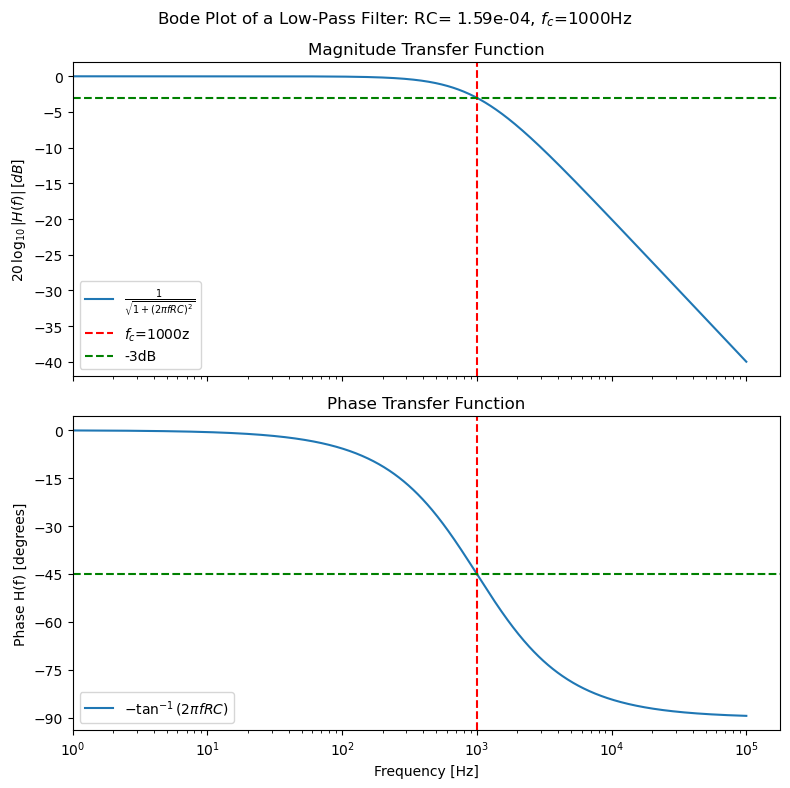

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def H(f, RC):
    return 1 / (np.sqrt(1 + (2 * np.pi * f * RC)**2))

def f_c(RC):
    return 1 / (2 * np.pi * RC)

def phi(f, RC):
    return np.arctan(-2 * np.pi * f * RC)

# Component values
R = 1e3
C = 1e-6

RC= R*C
RC = 1e-3 / (2* np.pi) 
# Frequency range

freqs = np.logspace(0, 5, 1000)

# Calculate magnitude and phase responses
H_values = H(freqs, RC)
phi_values = phi(freqs, RC)
f_cutoff = f_c(RC)
print(f_cutoff)
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

# Plot magnitude response
ax1.plot(freqs, 20 * np.log10(H_values), label=r'$\frac{1}{\sqrt{1 + (2 \pi f RC)^2}}$')
ax1.set_xscale('log')
ax1.set_title('Magnitude Transfer Function')
ax1.axvline(f_cutoff, color='red', linestyle='--', label=f'$f_c$={f_cutoff:.0f}z')
ax1.axhline(-3, color='green', linestyle='--', label='-3dB')
ax1.set_ylabel('$20 \,\log_{10}|H(f)| \, [dB]$')
ax2.set_xlabel('Frequency [Hz]')
ax1.legend()
ax1.set_xlim(1)

# Plot phase response
ax2.plot(freqs, np.rad2deg(phi_values), label=r'$-\tan^{-1}(2 \pi f RC)$')
ax2.axvline(f_cutoff, color='red', linestyle='--')
ax2.axhline(-45, color='green', linestyle='--')
ax2.set_title('Phase Transfer Function')
ax2.set_ylabel('Phase H(f) [degrees]')
ax2.set_yticks(np.arange(-90, 1, 15))
ax2.legend(loc='lower left')

# Show plot
plt.suptitle(f'Bode Plot of a Low-Pass Filter: RC= {RC:.2e}, $f_c$={f_cutoff:.0f}Hz')
plt.tight_layout()
plt.savefig('pdf/bode_plot.pdf')
plt.show()

-21.80140948635181
-38.659808254090095
-45.0
-63.43494882292201
-75.96375653207353
-84.28940686250037
-89.28384005452959
H values = [0.92847669 0.78086881 0.70710678 0.4472136  0.24253563 0.09950372
 0.01249902]


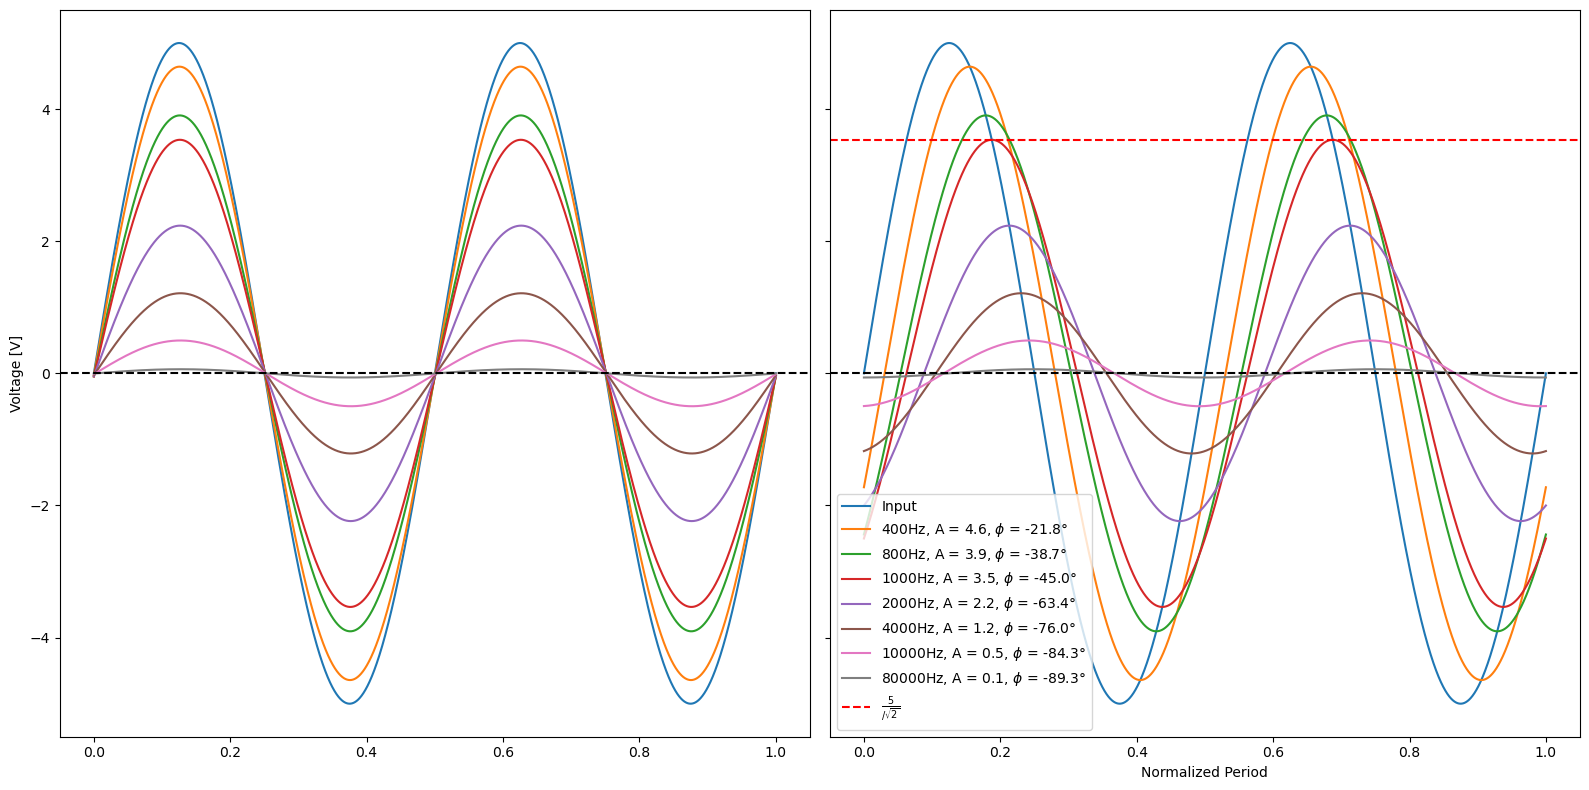

400Hz, Power in: 25.00, Power out: 21.55
H_mag: 0.93, Gain:-0.64dB
 phase lag: -21.801409486353137
800Hz, Power in: 25.00, Power out: 15.24
H_mag: 0.78, Gain:-2.15dB
 phase lag: -38.659808254089846
1000Hz, Power in: 25.00, Power out: 12.50
H_mag: 0.71, Gain:-3.01dB
 phase lag: -44.999999999994806
2000Hz, Power in: 25.00, Power out: 5.00
H_mag: 0.45, Gain:-6.99dB
 phase lag: -63.43494882292713
4000Hz, Power in: 25.00, Power out: 1.47
H_mag: 0.24, Gain:-12.30dB
 phase lag: -75.96375653204608
10000Hz, Power in: 25.00, Power out: 0.25
H_mag: 0.10, Gain:-20.04dB
 phase lag: -84.2894068624993
80000Hz, Power in: 25.00, Power out: 0.00
H_mag: 0.01, Gain:-38.06dB
 phase lag: -89.28384005450853


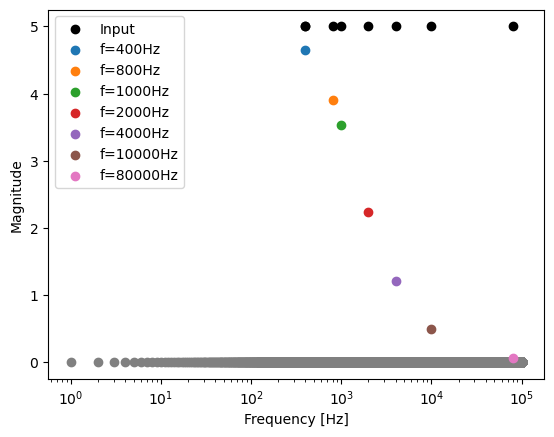

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


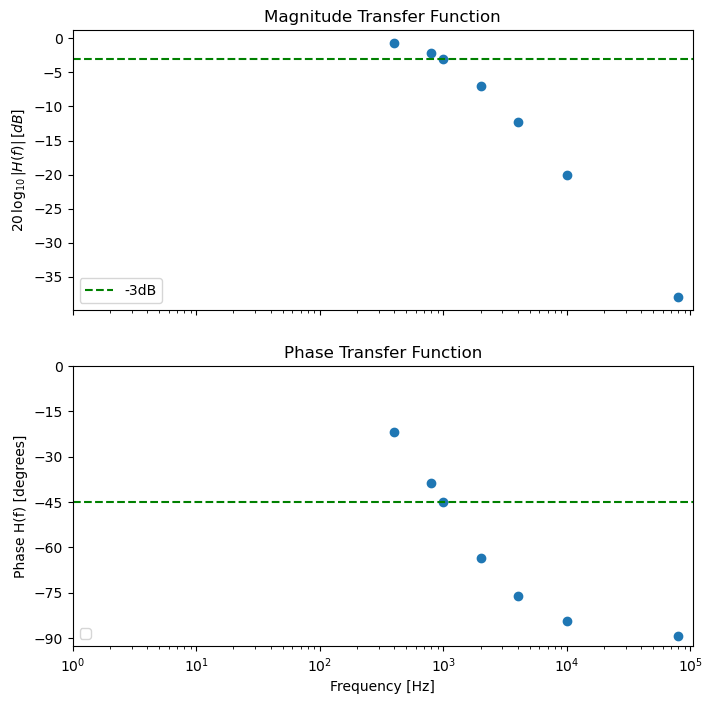

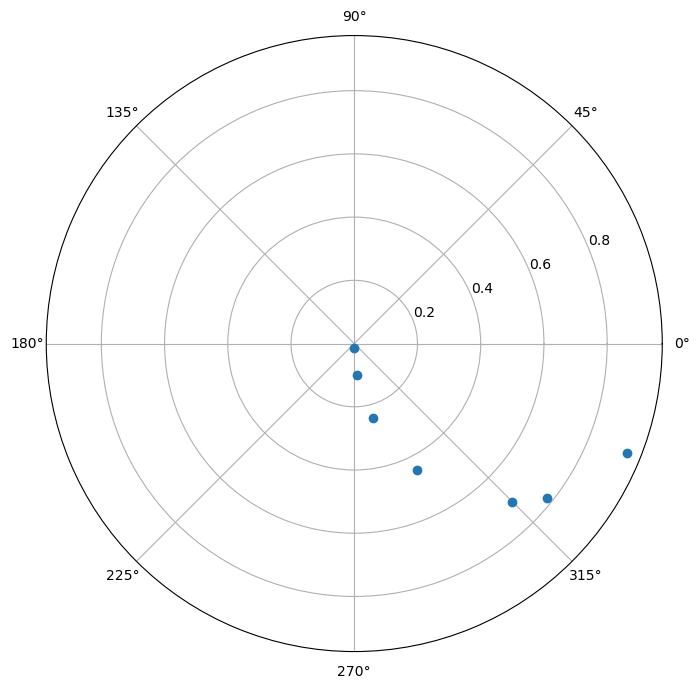

Fitted RC: 1.5915494309e-04 $\pm$ 1.7974002507e-20
Fitted RC: 1.5915494309e-04 $\pm$ 4.2947355522e-17


In [14]:
from scipy.optimize import curve_fit

daq = MyDAQ()

samplerate = 200000
frequency = 2
amplitude = 5


frequencies= [400,800, 1000, 2000, 4000, 10000, 80000]

start_freq = 1
stop_freq = 80000
number_of_data = 10
#frequencies = np.logspace(np.log10(start_freq), np.log10(stop_freq), number_of_data).astype(int)
cut_off = 1000
RC = 1 / (2 * np.pi * cut_off)
x_in, y_in = daq.generateWaveform('sine', samplerate, frequency, amplitude)
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
ax[0].plot(x_in, y_in, label='Input')
ax[1].plot(x_in, y_in, label='Input')
for f in frequencies:
    print(np.rad2deg(phi(f, RC)))
    x_out, y_out = daq.generateWaveform('sine', samplerate, frequency, 5*H(f, RC), phase=phi(f, RC))
    ax[0].plot(x_out, y_out, label=f'{f}Hz, A = {5*H(f, RC):.1f}, $\phi$ = {np.rad2deg(phi(f, RC)):.1f}°')
    
    
    x_out, y_out = daq.generateWaveform('sine', samplerate, frequency, 5*H(f, RC), phase=phi(f, RC), phaseInDegrees=False)
    ax[1].plot(x_out, y_out, label=f'{f}Hz, A = {5*H(f, RC):.1f}, $\phi$ = {np.rad2deg(phi(f, RC)):.1f}°')

frequencies = np.asarray(frequencies)
print(f'H values = {H(frequencies, RC)}')
ax[0].axhline(0, color='black', linestyle='--')
ax[1].axhline(0, color='black', linestyle='--')
plt.axhline(5/np.sqrt(2), color='red', linestyle='--', label=r'$\frac{5}{/\sqrt{2}}$')
plt.xlabel('Normalized Period')
ax[0].set_ylabel('Voltage [V]')
plt.legend()
plt.tight_layout()
plt.savefig('pdf/raw_data.pdf')
plt.show()  
H_complexs = []
for i, f in enumerate(frequencies):
    x_out, y_out = daq.generateWaveform('sine', samplerate, f, 5*H(f, RC), phase=phi(f, RC), phaseInDegrees=False)
    x_in, y_in = daq.generateWaveform('sine', samplerate, f, amplitude)
    freqs_in, fft_in = daq.performRFFT(y_in, samplerate)
    freqs_out, fft_out = daq.performRFFT(y_out, samplerate)
    
    #Mask for better PDF
    mask = np.abs(fft_in) > 1e-3
    if i == 0:
        plt.scatter(freqs_in[mask], np.abs(fft_in)[mask], color='black', label='Input')
        plt.scatter(freqs_in[~mask], np.abs(fft_in)[~mask], color='grey')
 
    plt.scatter(freqs_in[mask], np.abs(fft_in)[mask], color='black')
    plt.scatter(freqs_out[mask], np.abs(fft_out)[mask], label=f'f={f}Hz')
    
    
    delta_f = 100
    power_in = daq.power(freqs_in, fft_in, f, delta_f)
    power_out = daq.power(freqs_out, fft_out, f, delta_f)
    print(f'{f}Hz, Power in: {power_in:.2f}, Power out: {power_out:.2f}')
    H_mag = np.sqrt(power_out / power_in)
    print(f'H_mag: {H_mag:.2f}, Gain:{20*np.log10(H_mag):.2f}dB')

    fft_peak = np.argmax(np.abs(fft_in)) 
    phase_in = np.angle(fft_in)[fft_peak]
    phase_out = np.angle(fft_out)[fft_peak]
    H_arg = phase_out - phase_in
    
    H_complex = H_mag * np.exp(1j * H_arg)
    H_complexs.append(H_complex)
    
    print(f' phase lag: {np.rad2deg(H_arg)}')
    
    # Lets fuck around with errors.
    # Input values       
    relative_error_in = 0.01  # Relative error for input power (1%)        
    relative_error_out = 0.02  # Relative error for output power (2%)

    # Calculate the propagated relative error for the power ratio
    relative_error_ratio = np.sqrt(relative_error_in**2 + relative_error_out**2)
    # Output the propagated relative error
    #print("Propagated relative error on power_in / power_out:", relative_error_ratio)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xscale('log')
plt.legend()
plt.savefig('pdf/frequency_response.png')
plt.show()


def make_bode_plot(freqs, complex_H):

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

    # Plot magnitude response
    ax1.scatter(freqs, 20 * np.log10(np.abs(complex_H)))
    ax1.set_xscale('log')
    ax1.set_title('Magnitude Transfer Function')
    ax1.axhline(-3, color='green', linestyle='--', label='-3dB')
    ax1.set_ylabel('$20 \,\log_{10}|H(f)| \, [dB]$')
    ax2.set_xlabel('Frequency [Hz]')
    ax1.legend()
    ax1.set_xlim(1)

    # Plot phase response
    ax2.scatter(freqs, np.rad2deg(np.angle(complex_H)))

    ax2.axhline(-45, color='green', linestyle='--')
    ax2.set_title('Phase Transfer Function')
    ax2.set_ylabel('Phase H(f) [degrees]')
    ax2.set_yticks(np.arange(-90, 1, 15))
    ax2.legend(loc='lower left')
    ax2.set_xlim(1)
    return fig

def make_polar_plot(complex_H):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(8, 8))
    ax.plot(np.angle(complex_H), np.abs(complex_H), 'o')
    return fig
    
fig = make_bode_plot(frequencies, H_complexs)

# Save the figure
fig.savefig('pdf/bode_plot_analysis.pdf')
plt.show()

fig = make_polar_plot(H_complexs)
fig.savefig('pdf/polar_plot_analysis.pdf')
plt.show()

# Fit the data
RC_fitted_mag, cov = curve_fit(H, frequencies, np.abs(H_complexs), p0=[RC])

print(f'Fitted RC: {RC_fitted_mag[0]:.10e} $\pm$ {np.sqrt(cov[0, 0]):.10e}')

RC_fitted_phi, cov = curve_fit(phi, frequencies, np.angle(H_complexs), p0=[RC])

print(f'Fitted RC: {RC_fitted_phi[0]:.10e} $\pm$ {np.sqrt(cov[0, 0]):.10e}')

1Hz, Power in: 25.00, Power out: 25.00
H_mag: 1.00, Gain:-0.00dB
 phase lag: -0.05729576041450671
1Hz, Power in: 25.00, Power out: 25.00
H_mag: 1.00, Gain:-0.00dB
 phase lag: -0.05729576041450671
1Hz, Power in: 25.00, Power out: 25.00
H_mag: 1.00, Gain:-0.00dB
 phase lag: -0.05729576041450671
1Hz, Power in: 25.00, Power out: 25.00
H_mag: 1.00, Gain:-0.00dB
 phase lag: -0.05729576041450671
2Hz, Power in: 25.00, Power out: 25.00
H_mag: 1.00, Gain:-0.00dB
 phase lag: -0.11459140623777568
3Hz, Power in: 25.00, Power out: 25.00
H_mag: 1.00, Gain:-0.00dB
 phase lag: -0.17188682288003226
3Hz, Power in: 25.00, Power out: 25.00
H_mag: 1.00, Gain:-0.00dB
 phase lag: -0.17188682288003226
5Hz, Power in: 25.00, Power out: 25.00
H_mag: 1.00, Gain:-0.00dB
 phase lag: -0.28647651027705273
6Hz, Power in: 25.00, Power out: 25.00
H_mag: 1.00, Gain:-0.00dB
 phase lag: -0.34377055187146516
7Hz, Power in: 25.00, Power out: 25.00
H_mag: 1.00, Gain:-0.00dB
 phase lag: -0.4010639059666684
10Hz, Power in: 25.00

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 phase lag: -85.48506495812353
15945Hz, Power in: 25.00, Power out: 0.10
H_mag: 0.06, Gain:-24.07dB
 phase lag: -86.41136175247767
20077Hz, Power in: 25.00, Power out: 0.06
H_mag: 0.05, Gain:-26.06dB
 phase lag: -87.14855461644436
25279Hz, Power in: 25.00, Power out: 0.04
H_mag: 0.04, Gain:-28.06dB
 phase lag: -87.73464454308214
31830Hz, Power in: 25.00, Power out: 0.02
H_mag: 0.03, Gain:-30.06dB
 phase lag: -88.2005359740503
40077Hz, Power in: 25.00, Power out: 0.02
H_mag: 0.02, Gain:-32.06dB
 phase lag: -88.57065416163964
50461Hz, Power in: 25.00, Power out: 0.01
H_mag: 0.02, Gain:-34.06dB
 phase lag: -88.8647018331637
63537Hz, Power in: 25.00, Power out: 0.01
H_mag: 0.02, Gain:-36.06dB
 phase lag: -89.09830414895816
80000Hz, Power in: 25.00, Power out: 0.00
H_mag: 0.01, Gain:-38.06dB
 phase lag: -89.28384005450853


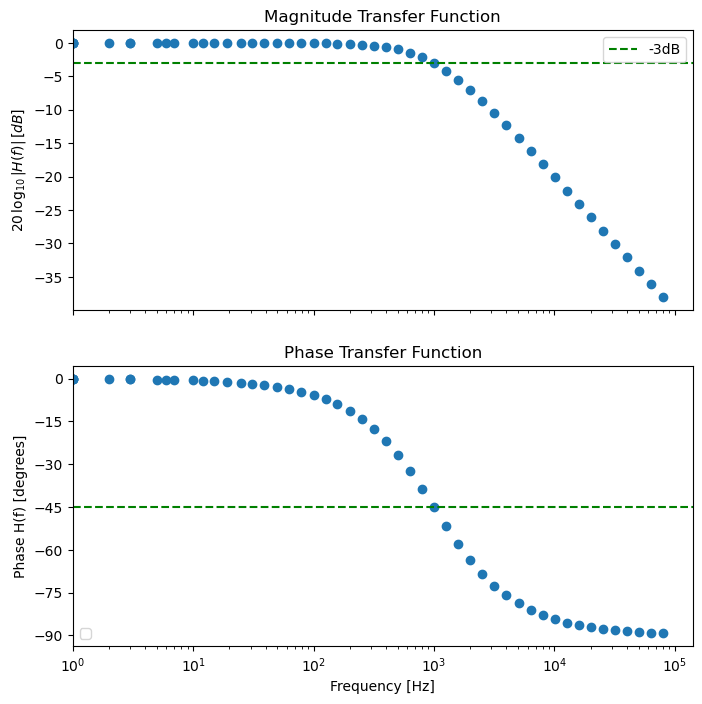

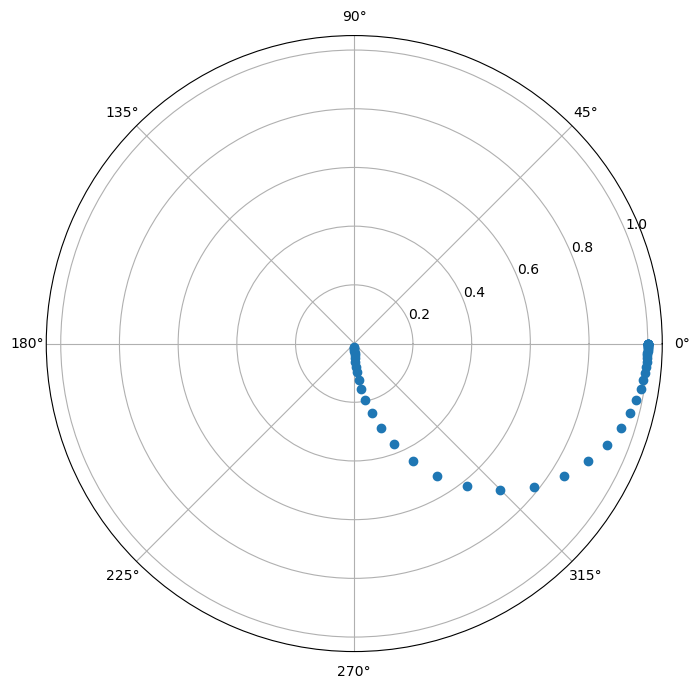

Fitted RC: 1.5915494309e-04 $\pm$ 3.0935864109e-20
Fitted RC: 1.5915494309e-04 $\pm$ 1.1649224571e-16


In [ ]:
from scipy.optimize import curve_fit

daq = MyDAQ()

samplerate = 200000
frequency = 2
amplitude = 5



start_freq = 1
stop_freq = 80000
number_of_data = 50
frequencies = np.logspace(np.log10(start_freq), np.log10(stop_freq), number_of_data).astype(int)
cut_off = 1000
RC = 1 / (2 * np.pi * cut_off)
# x_in, y_in = daq.generateWaveform('sine', samplerate, frequency, amplitude)
# fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
# ax[0].plot(x_in, y_in, label='Input')
# ax[1].plot(x_in, y_in, label='Input')
# for f in frequencies:
#     print(np.rad2deg(phi(f, RC)))
#     x_out, y_out = daq.generateWaveform('sine', samplerate, frequency, 5*H(f, RC), phase=phi(f, RC))
#     ax[0].plot(x_out, y_out, label=f'{f}Hz, A = {5*H(f, RC):.1f}, $\phi$ = {np.rad2deg(phi(f, RC)):.1f}°')
    
    
#     x_out, y_out = daq.generateWaveform('sine', samplerate, frequency, 5*H(f, RC), phase=phi(f, RC), phaseInDegrees=False)
#     ax[1].plot(x_out, y_out, label=f'{f}Hz, A = {5*H(f, RC):.1f}, $\phi$ = {np.rad2deg(phi(f, RC)):.1f}°')


# ax[0].axhline(0, color='black', linestyle='--')
# ax[1].axhline(0, color='black', linestyle='--')
# plt.axhline(5/np.sqrt(2), color='red', linestyle='--', label=r'$\frac{5}{/\sqrt{2}}$')
# plt.xlabel('Normalized Period')
# ax[0].set_ylabel('Voltage [V]')
# plt.legend()
# plt.tight_layout()
# plt.savefig('pdf/raw_data.pdf')
# plt.show()  
H_complexs = []
for i, f in enumerate(frequencies):
    x_out, y_out = daq.generateWaveform('sine', samplerate, f, 5*H(f, RC), phase=phi(f, RC), phaseInDegrees=False)
    x_in, y_in = daq.generateWaveform('sine', samplerate, f, amplitude)
    freqs_in, fft_in = daq.performRFFT(y_in, samplerate)
    freqs_out, fft_out = daq.performRFFT(y_out, samplerate)
    
    # #Mask for better PDF
    # mask = np.abs(fft_in) > 1e-3
    # if i == 0:
    #     plt.scatter(freqs_in[mask], np.abs(fft_in)[mask], color='black', label='Input')
    #     plt.scatter(freqs_in[~mask], np.abs(fft_in)[~mask], color='grey')
 
    # plt.scatter(freqs_in[mask], np.abs(fft_in)[mask], color='black')
    # plt.scatter(freqs_out[mask], np.abs(fft_out)[mask], label=f'f={f}Hz')
    
    
    delta_f = 100
    power_in = daq.power(freqs_in, fft_in, f, delta_f)
    power_out = daq.power(freqs_out, fft_out, f, delta_f)
    print(f'{f}Hz, Power in: {power_in:.2f}, Power out: {power_out:.2f}')
    H_mag = np.sqrt(power_out / power_in)
    print(f'H_mag: {H_mag:.2f}, Gain:{20*np.log10(H_mag):.2f}dB')

    fft_peak = np.argmax(np.abs(fft_in)) 
    phase_in = np.angle(fft_in)[fft_peak]
    phase_out = np.angle(fft_out)[fft_peak]
    H_arg = phase_out - phase_in
    
    H_complex = H_mag * np.exp(1j * H_arg)
    H_complexs.append(H_complex)
    
    print(f' phase lag: {np.rad2deg(H_arg)}')
    
    # Lets fuck around with errors.
    # Input values       
    relative_error_in = 0.01  # Relative error for input power (1%)        
    relative_error_out = 0.02  # Relative error for output power (2%)

    # Calculate the propagated relative error for the power ratio
    relative_error_ratio = np.sqrt(relative_error_in**2 + relative_error_out**2)
    # Output the propagated relative error
    #print("Propagated relative error on power_in / power_out:", relative_error_ratio)

# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Magnitude')
# plt.xscale('log')
# plt.legend()
# plt.savefig('pdf/frequency_response.png')
# plt.show()


def make_bode_plot(freqs, complex_H):

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

    # Plot magnitude response
    ax1.scatter(freqs, 20 * np.log10(np.abs(complex_H)))
    ax1.set_xscale('log')
    ax1.set_title('Magnitude Transfer Function')
    ax1.axhline(-3, color='green', linestyle='--', label='-3dB')
    ax1.set_ylabel('$20 \,\log_{10}|H(f)| \, [dB]$')
    ax2.set_xlabel('Frequency [Hz]')
    ax1.legend()
    ax1.set_xlim(1)

    # Plot phase response
    ax2.scatter(freqs, np.rad2deg(np.angle(complex_H)))

    ax2.axhline(-45, color='green', linestyle='--')
    ax2.set_title('Phase Transfer Function')
    ax2.set_ylabel('Phase H(f) [degrees]')
    ax2.set_yticks(np.arange(-90, 1, 15))
    ax2.legend(loc='lower left')
    ax2.set_xlim(1)
    return fig

def make_polar_plot(complex_H):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(8, 8))
    ax.plot(np.angle(complex_H), np.abs(complex_H), 'o')
    return fig
    
fig = make_bode_plot(frequencies, H_complexs)

# Save the figure
fig.savefig('pdf/bode_plot_analysis_LARGE.pdf')
plt.show()

fig = make_polar_plot(H_complexs)
fig.savefig('pdf/polar_plot_analysis_LARGE.pdf')
plt.show()

# Fit the data
RC_fitted_mag, cov = curve_fit(H, frequencies, np.abs(H_complexs), p0=[RC])

print(f'Fitted RC: {RC_fitted_mag[0]:.10e} $\pm$ {np.sqrt(cov[0, 0]):.10e}')

RC_fitted_phi, cov = curve_fit(phi, frequencies, np.angle(H_complexs), p0=[RC])

print(f'Fitted RC: {RC_fitted_phi[0]:.10e} $\pm$ {np.sqrt(cov[0, 0]):.10e}')

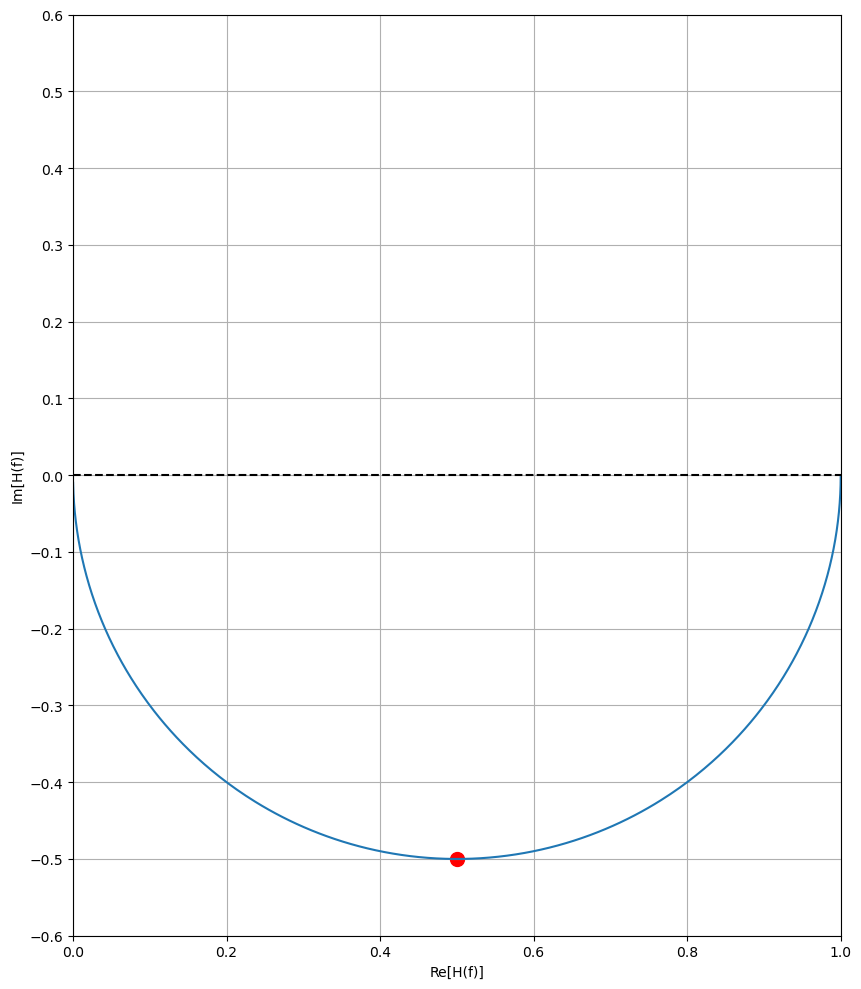

In [16]:
complex_H_values = H_values * np.exp(1j * phi_values)

plt.figure(figsize=(10, 10))

plt.plot(np.real(complex_H_values), np.imag(complex_H_values))
plt.xlim(0, 1)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Re[H(f)]')
plt.ylabel('Im[H(f)]')
plt.scatter(0.5, -0.5, s=100, color='red')
plt.yticks((np.arange(-0.6, 0.7, 0.1)))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.savefig('pdf/polar_plot.png')
plt.show()

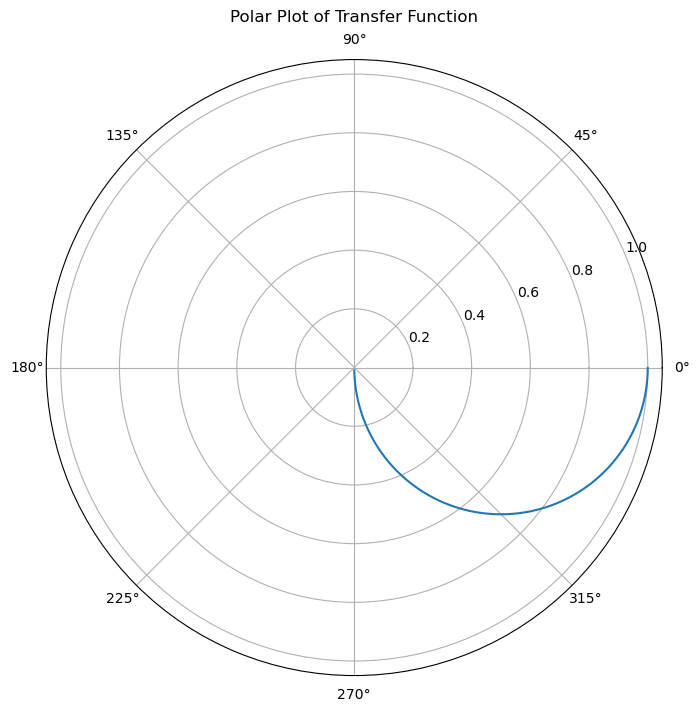

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming H_values and phi_values are already defined
complex_H_values = H_values * np.exp(1j * phi_values)

# Create a new figure with the specified size
plt.figure(figsize=(10, 8))

# Create a polar subplot
ax = plt.subplot(111, polar=True)

# Plot the phase (angle) vs. magnitude
ax.plot(np.angle(complex_H_values), np.abs(complex_H_values))

# Add a title
ax.set_title('Polar Plot of Transfer Function', va='bottom')


# Show the plot
plt.savefig('pdf/polar_plot_theory.pdf')
plt.show()

[0.9999995  0.99999949 0.99999947 0.99999946 0.99999944 0.99999943
 0.99999941 0.99999939 0.99999938 0.99999936 0.99999934 0.99999932
 0.9999993  0.99999928 0.99999926 0.99999924 0.99999922 0.9999992
 0.99999918 0.99999915 0.99999913 0.99999911 0.99999908 0.99999906
 0.99999903 0.999999   0.99999897 0.99999894 0.99999892 0.99999888
 0.99999885 0.99999882 0.99999879 0.99999875 0.99999872 0.99999868
 0.99999865 0.99999861 0.99999857 0.99999853 0.99999849 0.99999845
 0.9999984  0.99999836 0.99999831 0.99999826 0.99999822 0.99999817
 0.99999811 0.99999806 0.99999801 0.99999795 0.99999789 0.99999783
 0.99999777 0.99999771 0.99999765 0.99999758 0.99999751 0.99999744
 0.99999737 0.9999973  0.99999722 0.99999714 0.99999706 0.99999698
 0.9999969  0.99999681 0.99999672 0.99999663 0.99999653 0.99999644
 0.99999634 0.99999623 0.99999613 0.99999602 0.99999591 0.99999579
 0.99999568 0.99999555 0.99999543 0.9999953  0.99999517 0.99999503
 0.9999949  0.99999475 0.9999946  0.99999445 0.9999943  0.99999

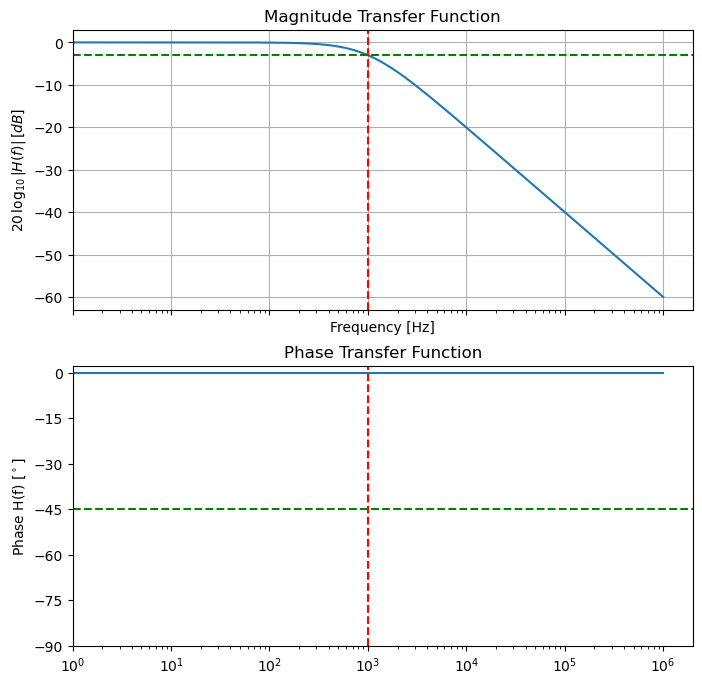

In [18]:
def H_complex(f, RC):
    return 1 / ((1 + (1j* (2 *np.pi *f * RC))))

def f_c(RC):
    return 1 / (2 * np.pi * RC)


# Component values
R = 1e3
C = 1e-6

RC= R*C
RC = 1e-3 / (2* np.pi) 

# Frequency range
freqs = np.logspace(0, 6, 1000)

# Calculate magnitude and phase responses
complex_H_values = H(freqs, RC)
print(complex_H_values)

f_cutoff = f_c(RC)
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

# Plot magnitude response
ax1.plot(freqs, 20 * np.log10(np.abs(complex_H_values)), label='R=1k, C=1u')
ax1.set_xscale('log')
ax1.set_title('Magnitude Transfer Function')
ax1.axvline(f_cutoff, color='red', linestyle='--', label='f_c=159Hz')
ax1.axhline(-3, color='green', linestyle='--', label='-3dB')
ax1.set_ylabel('$20 \,\log_{10}|H(f)| \, [dB]$')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_xlim(1)
ax1.set_yticks(np.arange(-60, 1, 10))  # Set y-ticks to steps of 10 dB
ax1.grid()

# Plot phase response
ax2.plot(freqs, np.rad2deg(np.angle(complex_H_values)), label='Phase')
ax2.axvline(f_cutoff, color='red', linestyle='--', label='f_c=159Hz')
ax2.axhline(-45, color='green', linestyle='--', label='-3dB')
ax2.set_title('Phase Transfer Function')
ax2.set_ylabel('Phase H(f) [$^\circ$]')
ax2.set_yticks(np.arange(-90, 1, 15))

# Show plot
plt.show()

Text(0, 0.5, 'Magnitude')

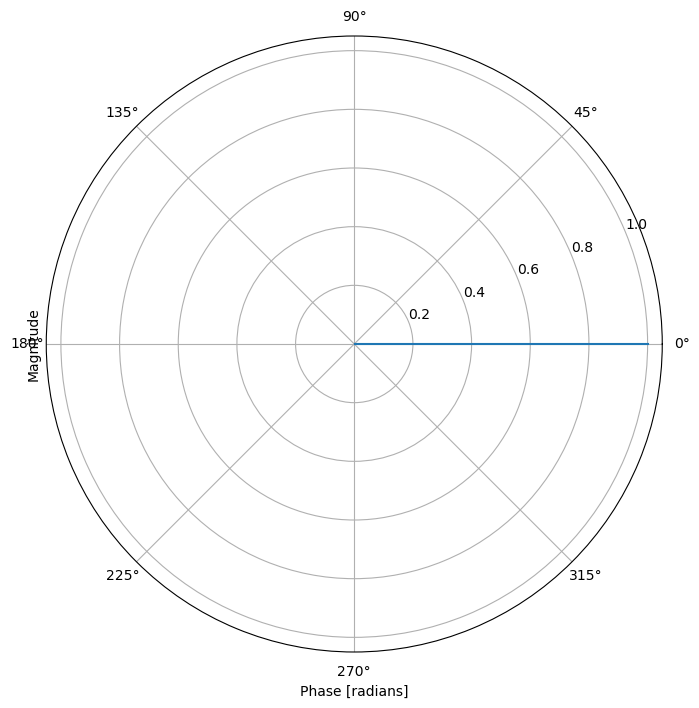

In [19]:
# Create a new figure with the specified size
plt.figure(figsize=(10, 8))

# Create a polar subplot
ax = plt.subplot(111, polar=True)

# Plot the magnitude and phase of the complex transfer function
ax.plot(np.angle(complex_H_values), np.abs(complex_H_values))

# Set labels
ax.set_xlabel('Phase [radians]')
ax.set_ylabel('Magnitude')

# Show the plot